# Facial Emotion Recognition - Prediction

## Import Libraries

In [2]:
### General imports ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from time import sleep
import re
import os
import argparse
from collections import OrderedDict
import matplotlib.animation as animation

### Image processing ###
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from imutils import face_utils

### Deep Learning models ###
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, ZeroPadding2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D, AveragePooling2D
#from tensorflow. keras.utils import np_utils
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import models
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.applications import densenet
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
### Same trained models ###
import h5py
from keras.models import model_from_json
import pickle

2024-06-18 19:36:58.171866: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
path = "/Users/ashrafmahmoud/Documents/ITI/9 Months/Core courses/Computer Vision/Projects/Emotion_Recognition_XCeption/challenges-in-representation-learning-facial-expression-recognition-challenge/"
folder_path = path + "Preprocessing_data/"

In [4]:
X_train = np.load(folder_path + "X_train.npy")
X_test = np.load(folder_path + "X_test.npy")
y_train = np.load(folder_path + "y_train.npy")
y_test = np.load(folder_path + "y_test.npy")

In [5]:
shape_x = 48
shape_y = 48

In [6]:
shape_x = 48
shape_y = 48
num_rows, num_cols, num_dims = X_train.shape[1:]
input_shape = (num_rows, num_cols, num_dims)
classes = np.unique(y_train)
nClasses = len(classes)

In [7]:
num_rows, num_cols, num_dims

(48, 48, 1)

## Face Detection

We need to detect the faces inside an image. This will allow us to :
- focus on the region of the face
- stop the prediction if no face is recognized.

To do so, we use `OpenCV face Cascade classifier`. Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, "Rapid Object Detection using a Boosted Cascade of Simple Features" in 2001. It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images.

The term "Cascade" comes from the fact that when a window is explored and no face edge is identified, the region is left apart and we move on to the next one using Adaboost classifier. This makes the overall process very efficient.

In [8]:
def detect_face(frame):
    
    #Cascade classifier pre-trained model
    cascPath = '/Users/ashrafmahmoud/Documents/ITI/9 Months/Core courses/Computer Vision/Projects/Emotion_Recognition_XCeption/Models/FaceDetection/haarcascade_frontalface_default.xml'
    faceCascade = cv2.CascadeClassifier(cascPath)
    
    #BGR -> Gray conversion
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    #Cascade MultiScale classifier
    detected_faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=6,
                                                  minSize=(shape_x, shape_y),
                                                  flags=cv2.CASCADE_SCALE_IMAGE)
    coord = []
    
    for x, y, w, h in detected_faces :
        if w > 100 :
            sub_img=frame[y:y+h,x:x+w]
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0, 255,255),1)
            coord.append([x,y,w,h])
    
    return gray, detected_faces, coord

In [9]:
# Extract facial features
def extract_face_features(faces, offset_coefficients=(0.075, 0.05)):
    gray = faces[0]
    detected_face = faces[1]
    
    new_face = []
    
    for det in detected_face :
        # Region in which the face is detected
        x, y, w, h = det   ## X and y correspond to the conversion to gray by gray, and w, h correspond to the height/width
    
        # Offset coefficient, np.floor takes the lowest integer (delete border of the image)
        horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
        vertical_offset = np.int(np.floor(offset_coefficients[1] * h))

        # gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # transform the image to gray
        extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]
    
        # Zoom on the extracted face
        new_extracted_face = zoom(extracted_face, (shape_x / extracted_face.shape[0],shape_y / extracted_face.shape[1]))

        # type float
        new_extracted_face = new_extracted_face.astype(np.float32)

        # scale
        new_extracted_face /= float(new_extracted_face.max())

        #print(new_extracted_face)
    
        new_face.append(new_extracted_face)
    
    return new_face

### Test

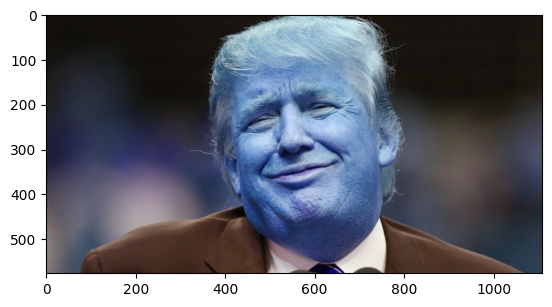

In [10]:
trump = '/Users/ashrafmahmoud/Documents/ITI/9 Months/Core courses/Computer Vision/Projects/Emotion_Recognition_XCeption/Images/Test_Images/trump.jpg'
trump_face = cv2.imread(trump, cv2.COLOR_BGR2RGB)
plt.imshow(trump_face)

### Extract Face

/Users/ashrafmahmoud/miniconda3/envs/cvenv/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
/Users/ashrafmahmoud/miniconda3/envs/cvenv/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review 

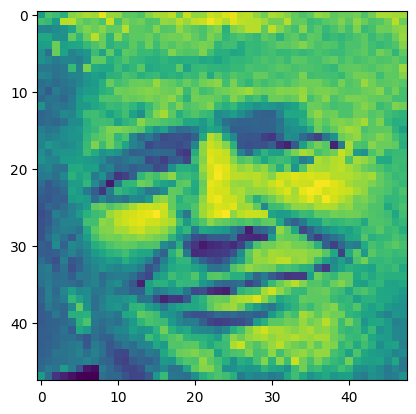

In [11]:
face = extract_face_features(detect_face(trump_face))[0]
plt.imshow(face)

In [12]:
model = load_model('/Users/ashrafmahmoud/Documents/ITI/9 Months/Core courses/Computer Vision/Projects/Emotion_Recognition_XCeption/Models/EmotionRecognition/xception_model.h5')

2024-06-18 19:37:08.089850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:

for face in extract_face_features(detect_face(trump_face)) :
    to_predict = np.reshape(face.flatten(), (1,48,48,1))
    res = model.predict(to_predict)
    result_num = np.argmax(res)
    print(result_num)

/Users/ashrafmahmoud/miniconda3/envs/cvenv/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
/Users/ashrafmahmoud/miniconda3/envs/cvenv/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review 

1/1 [==============================] - 1s 1s/step
3


- This corresponds to the `Happy` Labels which is a good prediction.

## Enhance the Visualization

This basic step is now woring properly and results are quite satisfying. There are lots of sources of improvements we'll try to implement over time :

- take into account the frequency of eye blinks
- display all the keypoints of the face
- align the face by scaling of the facial features

### a. Frequency of eye blink

In [14]:
def eye_aspect_ratio(eye):
	A = distance.euclidean(eye[1], eye[5])
	B = distance.euclidean(eye[2], eye[4])
	C = distance.euclidean(eye[0], eye[3])
	ear = (A + B) / (2.0 * C)   ### Eye Aspect Ratio (EAR)
	return ear

In [15]:
thresh = 0.25
frame_check = 20
face_detect = dlib.get_frontal_face_detector()
predictor_landmarks = dlib.shape_predictor("/Users/ashrafmahmoud/Documents/ITI/9 Months/Core courses/Computer Vision/Projects/Emotion_Recognition_XCeption/Models/Landmarks/face_landmarks.dat")

In [16]:
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

### b. Detect Keypoints to plot them

In [17]:
(nStart, nEnd) = face_utils.FACIAL_LANDMARKS_IDXS["nose"]
(mStart, mEnd) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]
(jStart, jEnd) = face_utils.FACIAL_LANDMARKS_IDXS["jaw"]

(eblStart, eblEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eyebrow"]
(ebrStart, ebrEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eyebrow"]

### c. Face Alignment

In [18]:
desiredLeftEye=(0.35, 0.35)

def align(gray, rect):
    # convert the landmark (x, y)-coordinates to a NumPy array
    shape = predictor(gray, rect)
    shape = shape_to_np(shape)
 
    # extract the left and right eye (x, y)-coordinates
    (lStart, lEnd) = FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEyePts = shape[lStart:lEnd]
    rightEyePts = shape[rStart:rEnd]
        
    # compute the center of mass for each eye
    leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
    rightEyeCenter = rightEyePts.mean(axis=0).astype("int")
 
    # compute the angle between the eye centroids
    dY = rightEyeCenter[1] - leftEyeCenter[1]
    dX = rightEyeCenter[0] - leftEyeCenter[0]
    angle = np.degrees(np.arctan2(dY, dX)) - 180
        
    # compute the desired right eye x-coordinate based on the
    # desired x-coordinate of the left eye
    desiredRightEyeX = 1.0 - desiredLeftEye[0]
 
    # determine the scale of the new resulting image by taking
    # the ratio of the distance between eyes in the *current*
    # image to the ratio of distance between eyes in the
    # *desired* image
    dist = np.sqrt((dX ** 2) + (dY ** 2))
    desiredDist = (desiredRightEyeX - desiredLeftEye[0])
    desiredDist *= self.desiredFaceWidth
    scale = desiredDist / dist
        
    # compute center (x, y)-coordinates (i.e., the median point)
    # between the two eyes in the input image
    eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
            (leftEyeCenter[1] + rightEyeCenter[1]) // 2)
 
    # grab the rotation matrix for rotating and scaling the face
    M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
 
    # update the translation component of the matrix
    tX = self.desiredFaceWidth * 0.5
    tY = self.desiredFaceHeight * self.desiredLeftEye[1]
    M[0, 2] += (tX - eyesCenter[0])
    M[1, 2] += (tY - eyesCenter[1])
        
    # apply the affine transformation
    (w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
    #output = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)
    output = cv2.warpAffine(gray, M, (w, h), flags=cv2.INTER_CUBIC)
    # return the aligned face
    return output

### Final Prediction

In [19]:
# Start video capturing
video_capture = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    
    face_index = 0
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    rects = face_detect(gray, 1)
    # gray, detected_faces, coord = detect_face(frame)
    try : 
        for (i, rect) in enumerate(rects):

            shape = predictor_landmarks(gray, rect)
            shape = face_utils.shape_to_np(shape)

            # Identify face coordinates
            (x, y, w, h) = face_utils.rect_to_bb(rect)
            face = gray[y:y+h,x:x+w]

            # Zoom on extracted face
            face = zoom(face, (shape_x / face.shape[0],shape_y / face.shape[1]))

            # Cast type float
            face = face.astype(np.float32)

            # Scale
            face /= float(face.max())
            face = np.reshape(face.flatten(), (1, 48, 48, 1))

            # Make Prediction
            prediction = model.predict(face)
            prediction_result = np.argmax(prediction)

            # Rectangle around the face
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

            cv2.putText(frame, "Face #{}".format(i + 1), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            for (j, k) in shape:
                cv2.circle(frame, (j, k), 1, (0, 0, 255), -1)

            # Add prediction probabilities
            cv2.putText(frame, "----------------",(40,100 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
            cv2.putText(frame, "Emotional report : Face #" + str(i+1),(40,120 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
            cv2.putText(frame, "Angry : " + str(round(prediction[0][0],3)),(40,140 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
            cv2.putText(frame, "Disgust : " + str(round(prediction[0][1],3)),(40,160 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
            cv2.putText(frame, "Fear : " + str(round(prediction[0][2],3)),(40,180 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
            cv2.putText(frame, "Happy : " + str(round(prediction[0][3],3)),(40,200 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
            cv2.putText(frame, "Sad : " + str(round(prediction[0][4],3)),(40,220 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
            cv2.putText(frame, "Surprise : " + str(round(prediction[0][5],3)),(40,240 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
            cv2.putText(frame, "Neutral : " + str(round(prediction[0][6],3)),(40,260 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)

            # draw extracted face in the top right corner
            # frame[face_index * shape_x: (face_index + 1) * shape_x, -1 * shape_y - 1:-1, :] = cv2.cvtColor(face * 255, cv2.COLOR_GRAY2RGB)

            # Annotate main image with a label
            if prediction_result == 0 :
                cv2.putText(frame, "Angry",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            elif prediction_result == 1 :
                cv2.putText(frame, "Disgust",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            elif prediction_result == 2 :
                cv2.putText(frame, "Fear",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            elif prediction_result == 3 :
                cv2.putText(frame, "Happy",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            elif prediction_result == 4 :
                cv2.putText(frame, "Sad",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            elif prediction_result == 5 :
                cv2.putText(frame, "Surprise",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            else :
                cv2.putText(frame, "Neutral",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # Eye Detection and Blink Count
            leftEye = shape[lStart:lEnd]
            rightEye = shape[rStart:rEnd]

            # Compute Eye Aspect Ratio
            leftEAR = eye_aspect_ratio(leftEye)
            rightEAR = eye_aspect_ratio(rightEye)
            ear = (leftEAR + rightEAR) / 2.0

            # And plot its contours
            leftEyeHull = cv2.convexHull(leftEye)
            rightEyeHull = cv2.convexHull(rightEye)
            cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
            cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)

            # Compute total blinks and frequency
            #if ear < thresh:
                #flag += 1
                #cv2.putText(frame, "Blink", (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)

            #cv2.putText(frame, "Total blinks : " + str(flag), (40, 280 + 180*i), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
            #cv2.putText(frame, "Blink Frequency : " + str(int(flag/j)), (40, 220), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)

            # Detect Nose
            nose = shape[nStart:nEnd]
            noseHull = cv2.convexHull(nose)
            cv2.drawContours(frame, [noseHull], -1, (0, 255, 0), 1)

            # Detect Mouth
            mouth = shape[mStart:mEnd]
            mouthHull = cv2.convexHull(mouth)
            cv2.drawContours(frame, [mouthHull], -1, (0, 255, 0), 1)

            # Detect Jaw
            jaw = shape[jStart:jEnd]
            jawHull = cv2.convexHull(jaw)
            cv2.drawContours(frame, [jawHull], -1, (0, 255, 0), 1)

            # Detect Eyebrows
            ebr = shape[ebrStart:ebrEnd]
            ebrHull = cv2.convexHull(ebr)
            cv2.drawContours(frame, [ebrHull], -1, (0, 255, 0), 1)
            ebl = shape[eblStart:eblEnd]
            eblHull = cv2.convexHull(ebl)
            cv2.drawContours(frame, [eblHull], -1, (0, 255, 0), 1)

        cv2.putText(frame,'Number of Faces : ' + str(len(rects)),(40, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, 155, 1)
        cv2.imshow('Video', frame)
    except :
        pass
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 36ms/step
